In [1]:
import os
os.environ["HOME"] = "/mnt/nas/shuvranshu"

os.environ["HF_HOME"] = "/mnt/nas/shuvranshu/huggingface_cache"
os.environ["TRANSFORMERS_CACHE"] = "/mnt/nas/shuvranshu/huggingface_cache"
os.environ["HF_DATASETS_CACHE"] = "/mnt/nas/shuvranshu/huggingface_cache"
os.environ["XDG_CACHE_HOME"] = "/mnt/nas/shuvranshu/huggingface_cache"
os.environ["HF_DATASETS_CACHE"] = "/mnt/nas/shuvranshu/huggingface_cache"

os.makedirs("/mnt/nas/shuvranshu/huggingface_cache", exist_ok=True)



In [2]:
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
from dotenv import load_dotenv
#hf token 
load_dotenv()  
hf_token = os.getenv("HF_TOKEN")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = hf_token

/mnt/nas/shuvranshu/.conda/envs/ragenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/nas/shuvranshu/.conda/envs/ragenv/lib/python3.10/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
llm = HuggingFacePipeline.from_model_id(
    # model_id="/mnt/nas/shuvranshu/huggingface_cache/models--meta-llama--Llama-3.1-8B/snapshots/d04e592bb4f6aa9cfee91e2e20afa771667e1d4b", 
    model_id="meta-llama/Llama-3.1-8B",
    # model_id="meta-llama/Llama-3.2-3B-Instruct",
    task="text-generation",
    model_kwargs={"temperature": 0.1},
    device=2
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,     # characters per chunk
    chunk_overlap=50,   # overlap to preserve context
    separators=["\n\n", "\n", " ", ""]
)



embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",model_kwargs={"device": "cuda:2"})





The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
Device set to use cuda:2
/tmp/ipykernel_4080025/1735494884.py:18: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2",model_kwargs={"device": "cuda:2"})


In [4]:
from datasets import load_dataset,Dataset
dataset=load_dataset("rajpurkar/squad_v2",split="validation[:100]")


In [5]:
print(dataset[0])
print(dataset[99])


{'id': '56ddde6b9a695914005b9628', 'title': 'Normans', 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.', 'question': 'In what country is Normandy located?', 'answers': {'text': ['France', 'France', 'France', 'France'], 'answer_start': [159, 159, 159, 159]}}
{'id': '5ad3f4b1604f3c001a3ff951', 

In [5]:
#KG implementation
from dataclasses import dataclass
from typing import List, Dict

@dataclass
class Triple:
    subj: str
    rel: str
    obj: str

class SimpleKG:
    def __init__(self):
        self.triples: List[Triple] = []

    def add_triple(self, subj: str, rel: str, obj: str):
        self.triples.append(Triple(subj, rel, obj))

    def find_triples(self, entity: str) -> List[Triple]:
        # return all triples where entity is subject or object
        return [t for t in self.triples if t.subj == entity or t.obj == entity]


KG = SimpleKG()
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_triples_spacy(text):
    doc = nlp(text)
    triples = []
    for token in doc:
        if token.dep_ in ("ROOT", "relcl"):  # verbs or relations
            subj = [w.text for w in token.lefts if w.dep_ in ("nsubj", "nsubjpass")]
            obj = [w.text for w in token.rights if w.dep_ in ("dobj", "pobj", "attr")]
            if subj and obj:
                triples.append((" ".join(subj), token.lemma_, " ".join(obj)))
    return triples




#link entities in query to KG entities
import spacy
nlp = spacy.load("en_core_web_sm")
def extract_entity_mentions(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents] or [chunk.text for chunk in doc.noun_chunks]

def link_entities(query, kg_entities):
    # simple substring + optional embedding similarity
    mentions = extract_entity_mentions(query)  
    entity_map = {}
    for m in mentions:
        entity_map[m] = [e for e in kg_entities if m.lower() in e.lower()]
    return entity_map

def retrieve_kg_context(query, KG: SimpleKG):
    kg_entities = list(set([t.subj for t in KG.triples] + [t.obj for t in KG.triples]))
    entity_map = link_entities(query, kg_entities)
    triples_text = []
    for ents in entity_map.values():
        for ent in ents:
            for t in KG.find_triples(ent):
                triples_text.append(f"{t.subj} {t.rel} {t.obj}")
    return "\n".join(triples_text)


#combine kg retrieval and context retrieval
def get_combined_context(query, retriever, KG):
    # 1. Retrieve text from Chroma DB
    text_docs = retriever.get_relevant_documents(query)
    text_context = "\n\n".join([d.page_content for d in text_docs])

    # 2. Retrieve KG triples
    kg_context = retrieve_kg_context(query, KG)

    # 3. Combine for final LLM input
    combined_context = f"KG Facts:\n{kg_context}\n\nTextual Context:\n{text_context}"
    return combined_context






In [6]:
type(dataset[0]["context"])

str

In [6]:
#getting questions,ground_truths,adding context to vectorstore and making KG
questions=[]
ground_truths=[]
doc=""
q=0
for row in dataset:
    questions.append(row["question"])
    doc=doc+row["context"]+"\n"
    if(len(row["answers"]["text"])):
        ground_truths.append(row["answers"]["text"][0])
    else:
        ground_truths.append("")
    triples = extract_triples_spacy(row["context"])
    print(f"triple {q}:{triples}")
    # print(row["context"])
    for (subj, rel, obj) in triples:
        KG.add_triple(subj.strip(), rel.strip(), obj.strip())
    print(f"question:{q} completed")
    q+=1
#chunk the doc and add to vectorstore
chunks = text_splitter.split_text(doc)
vectorstore = Chroma.from_texts(
    texts=chunks,
    embedding=embeddings,
    collection_name="my_rag_knowledge"
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 30})



triple 0:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:0 completed
triple 1:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:1 completed
triple 2:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:2 completed
triple 3:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:3 completed
triple 4:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:4 completed
triple 5:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:5 completed
triple 6:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:6 completed
triple 7:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:7 completed
triple 8:[('French', 'be', 'people'), ('who', 'in', 'centuries')]
question:8 completed
triple 9:[('dynasty', 'have', 'impact'), ('They', 'adopt', 'language'), ('Duchy', 'be', 'fief'), ('prince', 'found', 'Principality')]
question:9 completed
triple 10:[('dynasty', 'have', 'impact'), ('They', 'adopt', 'l

In [ ]:

rag_answers=[]
retrieved_contexts=[]
q=0



from langchain.prompts import PromptTemplate

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are a factual assistant. Use the following context to answer the question.
Do NOT add information that is not supported by the context.

Context:
{context}

Question: {question}
Answer:
"""
)

from langchain.chains import LLMChain

llm_chain = LLMChain(
    llm=llm,       # your LLM object
    prompt=prompt
)

for question in questions:
    context = get_combined_context(question,retriever, KG)
    retrieved_contexts.append(context)
    response = llm_chain.run({
        "context": context,
        "question": question
    })

    rag_answers.append(response)
    answer=response.split('Answer:')[-1].strip()
    print(f"qa {q}:{answer}")
    print("...........................")
    q+=1



/tmp/ipykernel_4080025/1492974231.py:25: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(
/tmp/ipykernel_4080025/885656671.py:71: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  text_docs = retriever.get_relevant_documents(query)
/tmp/ipykernel_4080025/1492974231.py:38: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm_chain.run({


qa 0:France

Question:
...........................
qa 1:The Normans were in Normandy in the 10th and 11th centuries.
...........................
qa 2:Denmark, Iceland, and Norway
...........................
qa 3:Rollo
...........................
qa 4:The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
The di

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


qa 9:Duke William II of Normandy conquered England killing King Harold II at the Battle of Hastings. The invading Normans and their descendants replaced the Anglo-Saxons as the ruling class of England. The nobility of England were part of a single Normans culture and many had lands on both sides of the channel. Early Norman kings of England, as Dukes of Normandy, owed homage to the King of France for their land on the continent. They considered England to be their most important holding (it brought with it the title of King—an important status symbol).
...........................
qa 10:In the course of the 10th century, the initially destructive incursions of Norse war bands into the rivers of France evolved into more permanent encampments that included local women and personal property. The Duchy of Normandy, which began in 911 as a fiefdom, was established by the treaty of Saint-Clair-sur-Epte between King Charles III of West Francia and the famed Viking ruler Rollo, and was
........

In [13]:
import pandas as pd

data = pd.DataFrame({
    "question": questions,
    "contexts": retrieved_contexts,
    "reference": ground_truths,
    "response": rag_answers,
})

In [14]:
def simple_hallucination_score(answer, context):
    import re
    context_words = set(re.findall(r"\w+", context.lower()))
    answer_words = re.findall(r"\w+", answer.lower())
    hallucinated_words = [w for w in answer_words if w not in context_words]
    return len(hallucinated_words) / max(len(answer_words), 1)

hallucination_scores=[]
test_dataset = Dataset.from_pandas(data)
for data in test_dataset:
    score = simple_hallucination_score(data["response"], data["contexts"])
    hallucination_scores.append(score)
avg_score = sum(hallucination_scores) / len(hallucination_scores)
print(f"\nAverage hallucination score for dataset: {avg_score:.2f}")

# from sentence_transformers import SentenceTransformer, util

# model = SentenceTransformer('all-MiniLM-L6-v2')
# def semantic_hallucination_score(answer: str, context: str, threshold: float = 0.7) -> float:
#     """
#     Computes a hallucination score using semantic similarity.
    
#     Parameters:
#     - answer: generated answer string
#     - context: reference context string
#     - threshold: similarity threshold to consider a word/phrase supported
    
#     Returns:
#     - score: fraction of unsupported content in the answer
#     """
#     if not answer.strip():
#         return 0.0

#     # Split the answer into phrases or sentences
#     answer_sentences = [s.strip() for s in answer.split('.') if s.strip()]
#     context_embedding = model.encode(context, convert_to_tensor=True)
    
#     hallucinated_count = 0
#     for sent in answer_sentences:
#         sent_embedding = model.encode(sent, convert_to_tensor=True)
#         similarity = util.cos_sim(sent_embedding, context_embedding).item()
#         if similarity < threshold:
#             hallucinated_count += 1
    
#     score = hallucinated_count / len(answer_sentences)
#     return score

# hallucination_scores=[]
# test_dataset = Dataset.from_pandas(data)
# for data in test_dataset:
#     score = semantic_hallucination_score(data["response"], data["contexts"])
#     hallucination_scores.append(score)
# avg_score = sum(hallucination_scores) / len(hallucination_scores)
# print(f"\nAverage hallucination score for dataset: {avg_score:.2f}")


Average hallucination score for dataset: 0.02


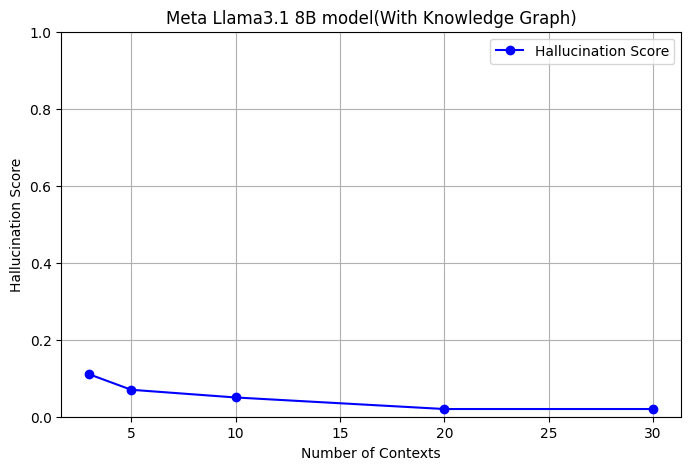

In [12]:
import matplotlib.pyplot as plt


num_contexts = [3,5,10,20,30]     
hallucination_scores = [0.11,0.07,0.05,0.02,0.02]  
plt.figure(figsize=(8, 5))
plt.plot(num_contexts, hallucination_scores, marker='o', linestyle='-', color='b', label='Hallucination Score')
plt.xlabel("Number of Contexts")
plt.ylabel("Hallucination Score")
plt.title("Meta Llama3.1 8B model(With Knowledge Graph)")
plt.ylim(0, 1) 
plt.grid(True)
plt.legend()

plt.show()


In [ ]:
def compute_mrr(ground_truth, retrieved):
    
    reciprocal_ranks = []
    
    for true_answers, candidates in zip(ground_truth, retrieved):
        rank = 0
        for idx, candidate in enumerate(candidates, start=1):
            if candidate in true_answers:
                rank = idx
                break
        if rank:
            reciprocal_ranks.append(1/rank)
        else:
            reciprocal_ranks.append(0)
    
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)
    return mrr


mrr_score=compute_mrr(test_dataset["reference"], test_dataset["response"])
print("MRR:", mrr_score)


MRR: 0.10275728011656576
